In [1]:
import sys
sys.path.append('../')

import numpy as np

from fmodeling.ForwardProcessing1D import forward_with_trace_calcing
from Inversion.Strategies.SeismDiffInversion1D import inverse
from Inversion.Optimizators.Optimizations import LBFGSBOptimization, DifferentialEvolution, TrustKrylov, TrustConstr, \
    ConjugateGradient
from Tests.test_ForwardProcessing1D import get_model_2layered, get_model_3layered
from Data.geol_models import get_model_3layered_fluid_rp_dicts
from objects.Data.WavePlaceholder import OWT, WaveDataPlaceholder
from objects.Models.Models import SeismicModel1D
from objects.Attributes.RockPhysics.RockPhysicsAttribute import RockPhysicsAttribute
from objects.Attributes.Seismic.SeismicAttribute import SeismicAttribute
from objects.Models.Layer1D import Layer1D, LayerOPT
import time

from matplotlib import pyplot as plt
from Inversion.Strategies.SeismDiffInversion1D import func_to_optimize


In [2]:
def plot_1D_err(forward_params, nvals, min_max=None, dot=False, vline_x=None):
    
    if min_max is None:
        min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
        max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
        
    else:
        min_val = np.array([min_max[0]])
        max_val = np.array([min_max[1]])
    
    dval = (max_val - min_val) / nvals

    val_x = [min_val + dval*i for i in range(nvals+1)]
    errs = []
    for val in val_x:
        errs.append(func_to_optimize(val, placeholders, forward_params, helper=None, show_tol=False))
        
    plt.plot(val_x, errs)
    if dot:
        plt.plot(val_x, errs, 'o')
        
    if vline_x is not None:
        plt.vlines(vline_x, ymin=min(errs), ymax=max(errs), colors='r')
        
    plt.show()

def optimization_func_2D(forward_params, x, y):
    indexes_1 = np.arange(x.shape[0])
    indexes_2 = np.arange(x.shape[1])
    
    Z = np.zeros((x.shape[0], x.shape[1]))
    
    for ind1 in indexes_1:
        for ind2 in indexes_2:
            Z[ind1, ind2] = func_to_optimize([x[ind1, ind2], y[ind1, ind2]], placeholders, forward_params, helper=None, show_tol=False)
        
    return Z

def plot_2D_err(forward_params, nvals, ncontous=10, points=None):
    min_val = forward_params['model'].get_optimization_option("min", vectorize=True)
    max_val = forward_params['model'].get_optimization_option("max", vectorize=True)
    
    dval = (max_val - min_val) / nvals

    val_1_x = [min_val[0] + dval[0]*i for i in range(nvals[0]+1)]
    val_2_x = [min_val[1] + dval[1]*i for i in range(nvals[1]+1)]

    X, Y = np.meshgrid(val_1_x, val_2_x)

    Z = optimization_func_2D(forward_params, X, Y)
    
    plt.contourf(X, Y, Z, ncontous, cmap='seismic')
    plt.colorbar()
    
    if points is not None:
        plt.plot(points[0], points[1], marker='x', color='r')

# Четырехслойная модель с газоосадками

In [33]:
h = [
    67.5,
    22.5,
    20
]

In [118]:
layer_1_seism = {
    'vp': 1500,
    'vs': 700,
    'rho': 1000
}

layer_2_rp = {
    "name": "unconsolidated",
    "components": {
                    "Ksi": {
                      "value": 38,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
					"Gsi": {
                      "value": 44,
                      "optimize": False,
                      "min": 40,
                      "max": 50
                    },
					"rhosi": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Ksh": {
                      "value": 21.5,
                      "optimize": False,
                      "min": 20,
                      "max": 25
                    },
					"Gsh": {
                      "value": 7,
                      "optimize": False,
                      "min": 5,
                      "max": 10
                    },
					"rhosh": {
                      "value": 2.43,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kincl": {
                      "value": 36.9,
                      "optimize": False,
                      "min": 35,
                      "max": 40
                    },
                    "Gincl": {
                      "value": 31,
                      "optimize": False,
                      "min": 30,
                      "max": 35
                    },
                    "rhoincl": {
                      "value": 2.2,
                      "optimize": False,
                      "min": 2,
                      "max": 2.5
                    },
                    "Kfl": {
                      "value": 2.29,
                      "optimize": False,
                      "min": 0.5,
                      "max": 5
                    },
                    "rhofl": {
                      "value": 1,
                      "optimize": False,
                      "min": 0.5,
                      "max": 1.5
                    },
#                     "Vsi": {
#                       "value": 0.01,
#                       "optimize": False,
#                       "min": 0.5,
#                       "max": 0.99
#                     },
                    "Vsh": {
                      "value": 0.7,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "Vincl": {
                      "value": 0,
                      "optimize": True,
                      "min": 0.5,
                      "max": 0.99
                    },
                    "phi": {
                      "value": 0.74,
                      "optimize": False,
                      "min": 0.5,
                      "max": 0.99
                    }
                  }
}

layer_3_seism = {
    'vp': 2000,
    'vs': 1000,
    'rho': 2070
}

# посмотреть в дипломе Машки!
layer_4_seism = {
    'vp': 6600,
    'vs': 3600,
    'rho': 2600,
}

In [119]:
layer_1 = Layer1D(h[0],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_1_seism),
                  opt=LayerOPT.NO)
layer_2 = Layer1D(h[1],
                  rp_attribute=RockPhysicsAttribute(layer_2_rp['components'], layer_2_rp['name']),
                  seism_attribute=None,
                  opt=LayerOPT.RP)
layer_3 = Layer1D(h[2],
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_3_seism),
                  opt=LayerOPT.NO)
layer_4 = Layer1D(-1,
                  rp_attribute=None,
                  seism_attribute=SeismicAttribute(**layer_4_seism),
                  opt=LayerOPT.NO)

In [120]:
model = SeismicModel1D([layer_1, layer_2, layer_3, layer_4])

In [121]:
# Многоканальная коса

In [122]:
dx = 2
nx = 100
x_rec = [i * dx for i in range(1, nx+1)]
wave_types = [OWT.PdPu_water]
dt = 1e-04
tracelen = 2000

# Forward modeling

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


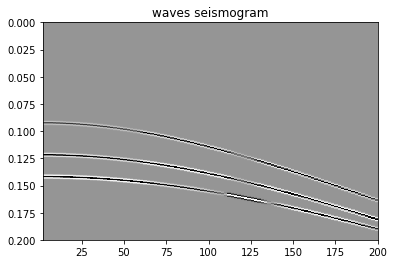

In [123]:
observe, test_seismic = \
    forward_with_trace_calcing(model, x_rec,
                               dt=dt, trace_len=tracelen, wavetypes=wave_types, display_stat=True,
        visualize_res=False, visualize_seismograms=True)

In [124]:
model.layers[0].seism_attribute.vals_dict

{'vp': 1500, 'vs': 700, 'rho': 1000}

In [125]:
model.layers[1].seism_attribute.vals_dict

{'vp': 1534.1089459244965, 'vs': 200.08822703140874, 'rho': 1353.8600000000001}

# Inversion

In [126]:
forward_params = {
    "model": model,
    "x_rec": x_rec,
    "dt": dt,
    "trace_len": tracelen,
    "wavetypes": wave_types,
    "display_stat": False,
    "visualize_res": False
}

In [127]:
placeholders = {}
for wt in wave_types:
    placeholders[wt] = WaveDataPlaceholder(
        wt,
        test_seismic[wt]["rays"],
        test_seismic[wt]["seismogram"]
    )

In [128]:
optimizers_de = [
    DifferentialEvolution(
          popsize= 5,
          maxiter= 20000,
          init= "latinhypercube",
          strategy= "best1bin",
          disp= False,
          polish= False,
          tol= 0.00001,
          mutation= 1.5,
          recombination= 0.6,
          workers= 8
    )
]

In [129]:
forward_params['model'].get_optimization_option('val')

OrderedDict([(1, {'Vincl': 0})])

In [130]:
forward_params['model'].get_optimization_option('val', vectorize=True)

array([0])

In [131]:
func_to_optimize(forward_params['model'].get_optimization_option('val', vectorize=True), placeholders, forward_params, helper=None, show_tol=False)

99999

In [109]:
# scale="minmax"
scale=None
# start_time = time.time()
inversed_model = inverse(optimizers_de, error=0.01, placeholders=placeholders, forward_params=forward_params, scale=scale)
# print(f"DE time: {time.time() - start_time}")

/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py:454: UserWarning: differential_evolution: the 'workers' keyword has overridden updating='immediate' to updating='deferred'
  " updating='deferred'", UserWarning)


0.025845952708066725
0.04607339945312057
0.0146561888325678
0.04792618748701155
0.04608522969827218
0.003034923460128952
0.03446814845073033
0.012640244907919552
0.034016340178032525
0.02284199527492901
0.011587904965692283
0.005974182280741431
0.04984581551798954
0.039104402978865464
0.043773624856432845
0.04379184999037451
0.027921058271797906
0.03685708649553345
0.017644697646684238
0.017182960687681124
0.015660808134498237
0.005387192458997164
0.005990880592371852
0.0053290151014505
0.01395369402301655
0.024499598539983236
0.03921008961989674
0.018545376145810855
0.04215793492118887
0.04036230274224924
0.01286699441421019
0.04349094798993081
0.003970528784911045
0.048889737680012625
0.013466956920330763
0.040451493123937185
0.04739133825101967
0.03528249176472915
0.017287470506952233
0.041630145238233225
0.03410956497058731
0.04472455931690319
0.043961198652929245
0.021624944638517468
0.03814840113253998
0.0171489703582109
0.03892172703926084
0.013202880537540177
0.0055213765944563

Process ForkPoolWorker-14:
Process ForkPoolWorker-16:
Process ForkPoolWorker-10:
Process ForkPoolWorker-15:
Process ForkPoolWorker-9:
Process ForkPoolWorker-13:
Process ForkPoolWorker-11:
Process ForkPoolWorker-12:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/process.py", l

  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/pool.py", line 121, in worker
    result = (True, func(*args, **kwds))
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/synchronize.py", line 95, in __enter__
    return self._semlock.__enter__()
  File "/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/ForwardProcessing1D.py", line 69, in forward
    result_rays[wt] = calculate_rays(observe, model, wt)
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/multiprocessing/pool.py", line 44, in mapstar
    return list(map(*args))
KeyboardInterrupt
  File "/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/ray_tracing/case_1D/forward_tracing1D.py", line 139, in calculate_rays
    rays[i] = calculate_rays_for_layer(model, observ, owt, i)
  File "/home/apenkin/miniconda3/envs/rpsi/lib/python3.7/site-packages/scipy/optimize/_differentialevolution.py", line 1012, in __call__
    return self.f(x, *self.args)
  File "/home/apenkin/workspace

KeyboardInterrupt: 

In [18]:
forward_params['model'].get_optimization_option("val", vectorize=True)

array([0.74])

In [19]:
inversed_model

array([0.73645576])

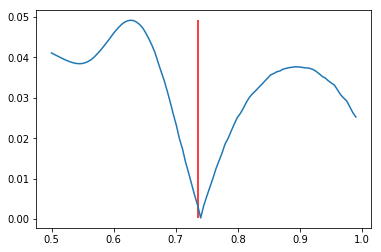

In [20]:
plot_1D_err(forward_params, 100, vline_x=inversed_model)

In [45]:
func_to_optimize(inversed_model, placeholders, forward_params, helper=None, show_tol=False)

/home/apenkin/workspace/rpsi_proj/rpsi/fmodeling/seismic/dynamic/bounds.py:61: ComplexWarning: Casting complex values to real discards the imaginary part
  angles[idx])


0.3551959812113167

Calculating rockphysics model...
Rockphysics model calculated!
Calculating PdPu_water-rays...


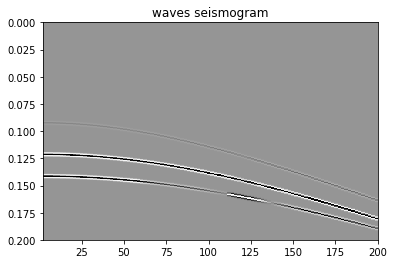

In [34]:
res_observe, res_seismic = forward_with_trace_calcing(forward_params['model'], forward_params['x_rec'], 
                           dt=forward_params['dt'], 
                           trace_len=forward_params['trace_len'], 
                           wavetypes=forward_params['wavetypes'],
            display_stat=True, visualize_res=False,
                               visualize_seismograms=True
            )

In [38]:
diff = test_seismic[OWT.PdPu_water]['seismogram'] - res_seismic[OWT.PdPu_water]['seismogram']

In [40]:
from Visualization.Seismic import visualize_seismogram


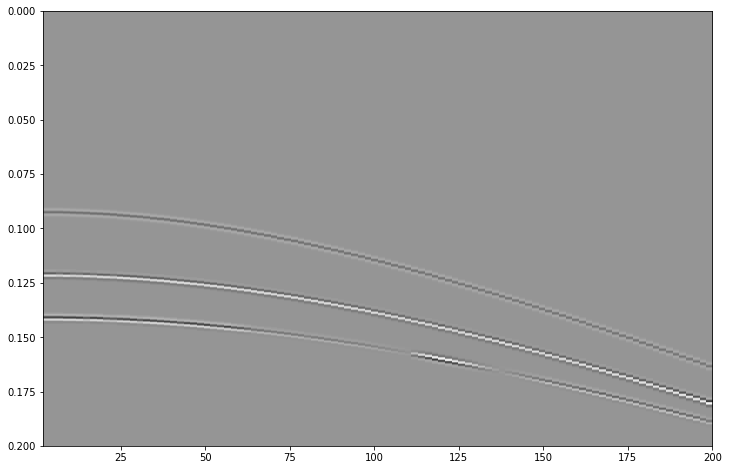

In [43]:
fig, ax = plt.subplots(figsize=(12,8))

visualize_seismogram(fig, ax, diff, wiggles=False)
